
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Google Brain - Ventilator Pressure Prediction</p>

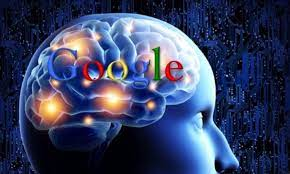



 <a id="1"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Importing Libraries</p>

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from termcolor import colored
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import zero_one_loss

<a id="2"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Loading Data</p>


## About the Dataset

### Files

- **train.csv** - the training set
- **test.csv** - the test set
- **sample_submission.csv** - a sample submission file in the correct format

### Columns
- `id` - globally-unique time step identifier across an entire file
- `breath_id` - globally-unique time step for breaths
- `R` - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
- `C` - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
- `time_step` - the actual time stamp.
- `u_in` - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.
- `u_out` - the control input for the exploratory solenoid valve. Either 0 or 1.
- `pressure` - the airway pressure measured in the respiratory circuit, measured in cmH2O.

In [ ]:
train_df=pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
test_df=pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
sample=pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')

<a id="tabular-exploration"></a>
<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:tOMATO; border:0; color:white' role="tab" aria-controls="home"><center>Tabular Exploration</center></h2>

In [ ]:
train_df.head()

In [ ]:
print(f"Training Dataset Shape: {colored(train_df.shape, 'red')}")
print(f"Test Dataset Shape: {colored(test_df.shape, 'red')}")

In [ ]:
train_df.info()

In [ ]:
train_df.isna().sum()

In [ ]:
for col in train_df.columns:
    print(col + ":" + colored(str(len(train_df[col].unique())), 'red'))

<a id="dataset-distribution"></a>
<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:red; border:0; color:white' role="tab" aria-controls="home"><center>Dataset Distribution</center></h2>

In [ ]:
def plot_distribution(x, title):
    
    """
    Function to obtain the distribution plot of given data.
    
    params: x(string)     : Name of the Column for the Plot.
            title(string) : Title of the Plot
    """
    sns.displot(train_df, x = x, kind="kde", bw_adjust=2)

    plt.title(title, fontsize = 15)
    plt.show()
plot_list = [("R", "Lung Airway Restricted"),
             ("C", "Lung Compliance"),
             ("u_in", "Control input for the inspiratory solenoid"),
             ("u_out", "Control input for the exploratory solenoid valve"),
             ("pressure", "Airway pressure")
            ]


In [ ]:
for column, title in plot_list:
    plot_distribution(x = column, title = title)   

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))
plt.subplot(2, 2, 1)
sns.countplot(x='R', data=train_df)
plt.title('Counts of R in train');
plt.subplot(2, 2, 2)
sns.countplot(x='R', data=test_df)
plt.title('Counts of R in test');
plt.subplot(2, 2, 3)
sns.countplot(x='C', data=train_df)
plt.title('Counts of C in train');
plt.subplot(2, 2, 4)
sns.countplot(x='C', data=test_df)
plt.title('Counts of C in test');

<a id="Feature corr"></a>
<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:red; border:2; color:white' role="tab" aria-controls="home"><center>Feature corr</center></h2>

In [ ]:
corr = train_df.corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(14, 14))

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap=None,
            cbar_kws={"shrink": .8}, vmin=0, vmax=1)
# yticks
plt.yticks(rotation=0)
plt.show()

In [ ]:
train_df.describe().style.background_gradient(cmap = 'copper')

In [ ]:
#grouping by pressur
train_df.groupby(train_df['pressure'].head(10)).agg('mean').style.background_gradient(cmap = 'copper')

In [ ]:
train_df[['u_in','u_out']].groupby(train_df['pressure']).agg('mean').head(20).plot(kind = 'bar')

In [ ]:
train_df[['breath_id','u_out']].groupby(train_df['pressure']).agg('mean').head(20).plot(kind ='hist')

In [ ]:
tech_list = train_df['pressure'].unique()
tech_list[:5]

In [ ]:
plt.figure(figsize=(10,6))
train_df['pressure'].plot()

In [ ]:
plt.figure(figsize=(10,6))
train_df['u_out'].plot()

In [ ]:
sns.pairplot(data=train_df.head(10))

In [ ]:
sns.heatmap(train_df.corr(),annot=True)

In [ ]:
X = train_df.iloc[:,:-1] 
y = train_df.iloc[:, -1]


In [ ]:
X

In [ ]:
y

In [ ]:
from sklearn.impute import SimpleImputer
ImputedModule = SimpleImputer(missing_values = np.nan, strategy ='mean' or 'median')
ImputedX = ImputedModule.fit(X)
X = ImputedX.transform(X)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_df)
print(scaler.mean_)
X = scaler.transform(train_df)
print("*********************************")
print(X)

###  Split Data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


### Using LinearRegression.

In [ ]:
LinearRegressionModel = LinearRegression()
LinearRegressionModel.fit(X_train, y_train)


In [ ]:
#Calculating Details
print('LinearRegressionModel Train Score is : ' , LinearRegressionModel.score(X_train, y_train))
print('LinearRegressionModel Test Score is : ' , LinearRegressionModel.score(X_test, y_test))


In [ ]:
#Calculating Prediction
y_pred = LinearRegressionModel.predict(X_test)
y_pred

In [ ]:
#Calculating Prediction
y_pred = LinearRegressionModel.predict(X_train)
y_pred

### Using  KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
KNeighborsRegressorModel = KNeighborsRegressor(n_neighbors = 3, weights='uniform')
KNeighborsRegressorModel.fit(X_train, y_train)

In [ ]:
#Calculating Details
print('KNeighborsRegressorModel Train Score is : ' , KNeighborsRegressorModel.score(X_train, y_train))
print('KNeighborsRegressorModel Test Score is : ' , KNeighborsRegressorModel.score(X_test, y_test))

In [ ]:
#Calculating Prediction
y_pred = KNeighborsRegressorModel.predict(X_test)
print('Predicted Value for KNeighborsRegressorModel is : ' , y_pred[:10])

In [ ]:
df = train_df[train_df['breath_id'] < 5].reset_index(drop=True)

In [ ]:
def plot_sample(sample_id, df):
    df_breath = df[df['breath_id'] == sample_id]
    r, c  = df_breath[['R', 'C']].values[0]

    cols = ['u_in', 'u_out', 'pressure'] if 'pressure' in df.columns else ['u_in', 'u_out']
    
    plt.figure(figsize=(12, 4))
    for col in ['u_in', 'u_out', 'pressure']:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)
        
    plt.legend()
    plt.title(f'Sample {sample_id} - R={r}, C={c}')

In [ ]:
for i in df['breath_id'].unique():
    plot_sample(i, train_df)

# Using Deep Learnung

In [ ]:
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, RobustScaler

In [ ]:
train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

X = train.drop(['pressure', 'breath_id'], axis=1)
y = train.pressure.values
test = test.drop('breath_id', axis=1)


scaler = StandardScaler()

X = scaler.fit_transform(X)
X_test = scaler.transform(test)

X = X.reshape(75450, 80, 5)
y = y.reshape(75450, 80)

X_test = X_test.reshape(50300, 80, 5)

# Using Bidirectional GRUs

In [ ]:
def model():
   
    input_ = keras.layers.Input(shape=(80, 5))
    x = keras.layers.Bidirectional(keras.layers.GRU(1024, return_sequences=True))(input_)
    x = keras.layers.Bidirectional(keras.layers.GRU(512, return_sequences=True))(x)
    x = keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True))(x)
    x = keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True))(x)
    x = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x)

    x = keras.layers.Dense(1000, activation='relu')(x)
    output_ = keras.layers.Dense(1)(x)

    model = keras.models.Model(inputs=input_, outputs=output_)
    
    return model

In [ ]:
dnn_model = model()

dnn_model.compile(optimizer=keras.optimizers.Nadam(), loss='mae')

In [ ]:
es = keras.callbacks.EarlyStopping(patience=30)
ls = keras.callbacks.ReduceLROnPlateau(patience=15, factor=0.7)

history_1 = dnn_model.fit(X[:2000], y[:2000], validation_split=0.3, batch_size=64, epochs=50, callbacks=[es, ls])

# Branch Bidirectional GRU neural net architecture(model 2)

In [ ]:
def get_split_data(X):
    data_A = np.zeros(X.shape)
    data_B = np.zeros(X.shape)
    
    data_A[:, :36, :] = X[:, :36, :]
    data_B[:, 36:, :] = X[:, 36:, :]
    
    return data_A, data_B
input_A = keras.layers.Input(shape=(80, 5))
input_B = keras.layers.Input(shape=(80, 5))
input_C = keras.layers.Input(shape=(80, 5))

input_A_masked = keras.layers.Masking(mask_value=0., input_shape=(80, 5))(input_A)
x_A = keras.layers.Bidirectional(keras.layers.GRU(512, return_sequences=True))(input_A_masked)
x_A = keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True))(x_A)
x_A = keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True))(x_A)
x_A = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x_A)
x_A = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x_A)
x_A = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x_A)

input_B_masked = keras.layers.Masking(mask_value=0., input_shape=(80, 5))(input_B)
x_B = keras.layers.Bidirectional(keras.layers.GRU(512, return_sequences=True))(input_B_masked)
x_B = keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True))(x_B)
x_B = keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True))(x_B)
x_B = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x_B)
x_B = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x_B)
x_B = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x_B)

x = keras.layers.Dense(1000, activation='relu')(tf.concat([x_A, x_B], axis=-1))

y_hat = keras.layers.Dense(1)(x)

model = keras.models.Model(inputs=[input_A, input_B], outputs=y_hat)

model.compile(optimizer=keras.optimizers.Nadam(), loss='mae')

data_A, data_B = get_split_data(X[:2000])
es = keras.callbacks.EarlyStopping(patience=30)
ls = keras.callbacks.ReduceLROnPlateau(patience=15, factor=0.7)

history_2 = model.fit(x=[data_A, data_B], y=y[:2000], validation_split=0.3, batch_size=64, epochs=50, callbacks=[es, ls])

# Branch Bidirectional GRU neural net architecture(model 3)

In [ ]:
input_A = keras.layers.Input(shape=(80, 5))
input_B = keras.layers.Input(shape=(80, 5))
input_C = keras.layers.Input(shape=(80, 5))

input_A_masked = keras.layers.Masking(mask_value=0., input_shape=(80, 5))(input_A)
x_A = keras.layers.Bidirectional(keras.layers.GRU(512, return_sequences=True))(input_A_masked)
x_A = keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True))(x_A)
x_A = keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True))(x_A)
x_A = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x_A)
x_A = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x_A)
x_A = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x_A)

input_B_masked = keras.layers.Masking(mask_value=0., input_shape=(80, 5))(input_B)
x_B = keras.layers.Bidirectional(keras.layers.GRU(512, return_sequences=True))(input_B_masked)
x_B = keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True))(x_B)
x_B = keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True))(x_B)
x_B = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x_B)
x_B = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x_B)
x_B = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x_B)

x_C = keras.layers.Bidirectional(keras.layers.GRU(1024, return_sequences=True))(input_C)
x_C = keras.layers.Bidirectional(keras.layers.GRU(512, return_sequences=True))(x_C)
x_C = keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True))(x_C)
x_C = keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True))(x_C)
x_C = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x_C)

x = keras.layers.Dense(1000, activation='relu')(tf.concat([x_A, x_B, x_C], axis=-1))

y_hat = keras.layers.Dense(1)(x)

model = keras.models.Model(inputs=[input_A, input_B, input_C], outputs=y_hat)

model.compile(optimizer=keras.optimizers.Nadam(), loss='mae')

data_A, data_B = get_split_data(X[:2000])
es = keras.callbacks.EarlyStopping(patience=30)
ls = keras.callbacks.ReduceLROnPlateau(patience=15, factor=0.7)


history_3 = model.fit(x=[data_A, data_B, X[:2000]], y=y[:2000], validation_split=0.3, batch_size=64, epochs=10, callbacks=[es, ls])

# Make a Compar

`CALCULATE THE VALIDATION`

In [ ]:
dictionary_1 = history_1.history
dictionary_2 = history_2.history
dictionary_3 = history_3.history
model_names = ['standard model', '2 Branch', '3 Branch']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax = ax.reshape(-1,)
for i, loss in enumerate([dictionary_1, dictionary_2, dictionary_3]):
    ax[0].plot(loss['val_loss'], label=f'Val Loss {model_names[i]}')
    ax[0].set_title('Validation Loss', fontsize=20)
    ax[0].set_xlabel('Epochs', fontsize=18)
    ax[0].set_ylabel('Mean Absolute Error', fontsize=18)
    ax[0].legend()
    ax[0].grid(alpha=0.4)
    
for i, loss in enumerate([dictionary_1, dictionary_2, dictionary_3]):
    ax[1].plot(loss['loss'], label=f'Training Loss {model_names[i]}')
    ax[1].set_title('Training Loss', fontsize=20)
    ax[1].set_xlabel('Epochs', fontsize=18)
    ax[1].set_ylabel('Mean Absolute Error', fontsize=18)
    ax[1].legend()
    ax[1].grid(alpha=0.4)